## Replicating Logistic Regression Models by Agarwal et al. (2013) and Liu et al. (2013)

In this notebook we are going to try to reproduce the Logistic Regression models by Agarwal et al. (2013) and Liu et al. (2013).

To achieve this we will have to complete the following steps:
* [Done] Merge the clicked and booked items within each query as positive instances. This will turn the classification task into a binary classification task.
* [Done] First, select a smaller feature set, consisting of the features: srch_id, prop_id, srch_destination_id, prop_starrating, prop_location_score1, prop_location_score_2, and price_usd (Liu et al., 2013). Later on, we can try to fit a model using a broader set of features.
* [Done] Split the data into a training and an internal validation set. For this dataset, Liu et al. (2013) used a validation set that was 10% of the original data size, generated using the rule: srch_id%10==1. Agarwal et al. (2013) explained that this selection rule minimzed the correlation between searches in close proximity i.e. searches with the same search_id. 
* [Done] (Also check how many instances there are of each search id). 
* [Done] To aid in the testing phase we sample a part of the data to train the model on e.g. 10.000 points.
* [Done] While both Agarwal et al. (2013) and Liu et al. (2013) added a class weight parameter to the cross-entropy function, we can initially try to use a balanced dataset instead. For this, we need to sample an equal number of positive and negative cases. Afterwards, we can try to fit a model with a weighted cross-entropy function as well.
* Binarize float features e.g. using the bucket algorithm presented by Liu et al. (2013)
* [Done] Sort the search queries based on the posterior probability of the Logistic Regression model. Here, the posterior probability serves as a measure for the relevance, directly. This approach was proposed by Agarwal et al. (2013).
* Finally, check the performance of the model using the NDCG@38 metric. For this, it is important to check whether the evaluation metric was implemented correctly, beforehand.
* Check out Automatic Relevance Determination Regression (ARD) (see: https://tinyurl.com/yblqaran).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure Visualization Defaults
%matplotlib inline

In [2]:
# Load the data
train = pd.read_csv('data/training_set_VU_DM.csv')

In [3]:
# For the experimental phase we select a subset of the training data
train_sub = train.loc[0:9999]

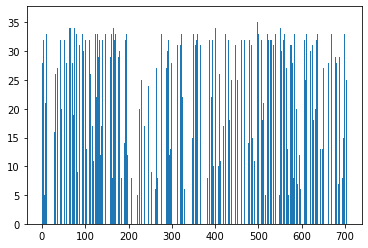

In [11]:
# Check how many instances there of each search_id on a subset of the data
# consisting of 10.000 points
u, c = np.unique(train_sub['srch_id'], return_counts=True)
plt.bar(u,c)
plt.show()

From the figure above we can see that the number of search results is not equal across search ids.

In [4]:
# Make the feature list that we are going to use for the first model
f_list = ['srch_id', 'prop_id', 'srch_destination_id', 'prop_starrating',
          'prop_location_score1', 'prop_location_score2', 'price_usd',
          'click_bool', 'booking_bool']

In [5]:
# Select the features from the f_list
train = train[f_list]

In [26]:
# Show the proportion of null values for each column
train.isna().sum()/train.shape[0]

srch_id                 0.000000
prop_id                 0.000000
srch_destination_id     0.000000
prop_starrating         0.000000
prop_location_score1    0.000000
prop_location_score2    0.219902
price_usd               0.000000
click_bool              0.000000
booking_bool            0.000000
dtype: float64

In [ ]:
# Show the distribution of the prop_location_score2 data
plt.hist(train['prop_location_score2'])
plt.show()

Since the above distribution shows outliers, we will use the median to impute the missing values.

In [6]:
# Impute the missing values of the prop_location_score2 variable
train['prop_location_score2'].fillna(np.nanmedian(train['prop_location_score2']),inplace=True)

In [7]:
# Merge the click and booking bools
train['merge_bool'] = train[['click_bool','booking_bool']].max(axis=1)

In [8]:
# Make the validation set
validation = train.loc[train['srch_id']%10==1]

In [9]:
# Make sure the train set does not contain the validation set
train = train.loc[train['srch_id']%10!=1]

In [37]:
# Check the shapes of the train and validation sets
print('train: ', train.shape[0])
print('validation: ', validation.shape[0])

train:  4461683
validation:  496664


In [10]:
# We subsample the training data
sub_1 = train[train['merge_bool'] == 1].sample(5000)
sub_0 = train[train['merge_bool'] == 0].sample(5000)
sub_even = pd.concat([sub_0, sub_1])

In [39]:
sub_even.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 3190909 to 2738809
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   srch_id               10000 non-null  int64  
 1   prop_id               10000 non-null  int64  
 2   srch_destination_id   10000 non-null  int64  
 3   prop_starrating       10000 non-null  int64  
 4   prop_location_score1  10000 non-null  float64
 5   prop_location_score2  10000 non-null  float64
 6   price_usd             10000 non-null  float64
 7   click_bool            10000 non-null  int64  
 8   booking_bool          10000 non-null  int64  
 9   merge_bool            10000 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 859.4 KB


We now try to fit a Logistic Regression model, using 5 and 10-fold cross validation.


In [11]:
# First we import the necessary functions
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [12]:
# Next we define the data and the outcome variables
X = sub_even[['prop_starrating','prop_location_score1',
              'prop_location_score2','price_usd']]
y = sub_even['merge_bool']

# Validation set
X_val = validation[['prop_starrating','prop_location_score1',
              'prop_location_score2','price_usd']]
y_val = validation['merge_bool']

In [13]:
# Now we fit the model using 5-fold cross-validation
clf5 = LogisticRegressionCV(cv=5).fit(X,y)
clf10 = LogisticRegressionCV(cv=10).fit(X,y)

In [14]:
# And show the performance of the model on the cross validated training data
print('CV5 score :', clf5.score(X,y))
print('CV10 score:', clf10.score(X,y))

CV5 score : 0.5824
CV10 score: 0.5817


In [15]:
# And show the performance of the cv models on the validation set
print('CV5 score :', clf5.score(X_val,y_val))
print('CV10 score:', clf10.score(X_val,y_val))

CV5 score : 0.6688606381779231
CV10 score: 0.6673525763896719


So it seems we can predict the merge bool reasonably well. The next step is to sort the search queries. Agarwal et al. (2013) have proposed to use the posterior probability directly as the relevance score for a search query.

After sorting, we can check whether our implementation of the evaluation metric (NDCG@38) works correctly.

## Evaluate model using NDCG@38

The following explanation of the evaluation metric used here, is taken directly from Agarwal et al. (2013):

"*Learning to rank methods require evaluation metrics that can account not only for class membership of the test set, but also relative ranking of the result. For our study, we use Normalized Discounted Cumulative Gain (NCDG) at position 38. NCDG is a commonly used benchmark in information retrieval [14], and was the measure used to determine the winner of the official Expedia learning to rank contest.*

*NDCG is defined in terms of Discounted Cumulative Gain (DCG). For a sequence of documents $X = \{x_1,\dots,x_n\}$ ranked in order of decreasing predicted relevance, and a relevance function $f(x)$, DCG at position $m < n$ is defined as:*

\begin{equation}
DCG_m(X) = \sum_{i=1}^m = \frac{2^{f(x_i)}-1}{\log_2(i+1)}
\end{equation}

*Normalized DCG simply divides by the best possible DCG for $X$, which is desirable because different test sets may have different best-case DCGs. Hence, NDCG returns a score that falls between zero and one, with one being a perfect score - that is, one where documents display monotonically decreasing relevence scores.*

*The relevance score used in our evaluation was also that provided in the official contest:*

\begin{equation}
f(x) =
\begin{cases}
5,& \text{if hotel booked}\\
1,& \text{if hotel clicked}\\
0,& \text{otherwise}\\
\end{cases}
\end{equation}

*The relevance function highly rewards hotel purchases, and marginally prefers clicks over no user action.*"

In [76]:
# Functions
def rel_func(clicking_bool,booking_bool):
    if booking_bool:
        return 5
    if clicking_bool:
        return 1
    else:
        return 0

def sort_seq(sequence):
    score_mat = np.empty([sequence.shape[0]])
    i = 0
    for _,s in sequence.iterrows():
        score_mat[i] = rel_func(s['click_bool'],s['booking_bool'])
        i += 1
    return np.argsort(score_mat)[::-1]

def dcgm38(sequence):
    score = 0
    i = 1
    for _, s in sequence.iterrows():
        score += (2**rel_func(s['click_bool'],\
                              s['booking_bool'])-1)/np.log2(i+1)
        i += 1
    return score

In [68]:
# We first sample all queries associated with 10 different search IDs
n_sample = 10
sample_srch_id = np.random.choice(np.unique(train['srch_id']),n_sample,replace=False)
print('sampled srch_id: ', sample_srch_id)
sample_train = pd.DataFrame()
for i in sample_srch_id:
    sample_train = pd.concat([sample_train,train.loc[train['srch_id']==i]])
    
X_sample = sample_train[['prop_starrating','prop_location_score1',
              'prop_location_score2','price_usd']]
y_sample = sample_train[['prop_starrating','prop_location_score1',
              'prop_location_score2','price_usd']]

sampled srch_id:  [329522 120522  64458 273813 307697 316623 211670 307664 288385 249355]


In [69]:
# Sort the queries based on the merge_bool
Ay = pd.DataFrame()
Ay['srch_id'] = sample_train['srch_id']
Ay['booking_bool'] = sample_train['booking_bool']
Ay['click_bool'] = sample_train['click_bool']

In [74]:
# Next we sort the queries using their associated posterior probabilities of a click and/or purchase
# derived from the Logistic Regression model.
rel_score5 = clf5.predict_proba(X_sample)
rel_score10 = clf10.predict_proba(X_sample)

A5 = pd.DataFrame()
A5['srch_id'] = sample_train['srch_id']
A5['booking_bool'] = sample_train['booking_bool']
A5['click_bool'] = sample_train['click_bool']
A5['rel_score5'] = rel_score5[:,1]
# A5['pred'] = clf5.predict(X_sample)

A10 = pd.DataFrame()
A10['srch_id'] = sample_train['srch_id']
A10['booking_bool'] = sample_train['booking_bool']
A10['click_bool'] = sample_train['click_bool']
A10['rel_score10'] = rel_score10[:,1]

A5_sort = pd.DataFrame()
A10_sort = pd.DataFrame()
# Sort
for i in sample_srch_id:
    A5_sort = pd.concat([A5_sort,A5.loc[A5['srch_id']==i].sort_values(by='rel_score5',ascending=False)])
    A10_sort = pd.concat([A10_sort,A10.loc[A10['srch_id']==i].sort_values(by='rel_score10',ascending=False)])

In [86]:
dcgm = np.empty(n_sample)
best = np.empty(n_sample)
for i in range(n_sample):
    dcgm[i] = dcgm38(A5_sort.loc[A5_sort['srch_id']==sample_srch_id[i]])
    A = sort_seq(Ay.loc[Ay['srch_id']==sample_srch_id[i]])
    best[i] = dcgm38(Ay.loc[Ay['srch_id']==sample_srch_id[i]].iloc[A])
    
print('DCG unsorted :', dcgm)
print('DCG sorted   :', best)
print('mean NDCG unsorted:', np.mean(np.divide(dcgm, best)))
print('mean NDCG sorted  :', np.mean(np.divide(best, best)))

DCG unsorted : [ 6.76123305  7.93469877 31.          0.33333333  7.93469877  9.77941118
  0.38685281 19.55882236  1.         15.5       ]
DCG sorted   : [31. 31. 31.  1. 31. 31.  1. 31.  1. 31.]
mean NDCG unsorted: 0.4896601112530224
mean NDCG sorted  : 1.0


Note that the NDCG score of almost 0.49 seems way too high(!) so this is very likely to have been a lucky draw.